# Self-Driving Car Engineer Nanodegree

## Vehicle Detection and Tracking

### Introduction
In this project the goal is to detect and mark vehicles in a video. Following the outline of the project I implemented a pipeline with:
1. Extract features from an image using gradient, color and spatial information.
2. Optimize feature extraction using different parameters
3. Train and analyze various classifiers
4. Optimize the chosen classifier
5. Implement a sliding window search
6. Implement a heatmap and maybe addtional mechanism to reduce false positives

## Data handling
As in the former projects I implemented a Data-Handling class to access training data for the classifier, load the project video and store the resulting video. Since the processing of the data takes some time I store the processed data in a separate file. These allows a fast training of various classifier later.

In [16]:
'''
Created on Nov 4, 2017

@author: andreas
'''

import glob
from moviepy.editor import VideoFileClip
import pickle

class DataHandling:
    def __init__(self):
        self.carDataPathes = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project5/Data/vehicles/*"
        self.nonCarDataPathes = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project5/Data/non-vehicles/*"
        self.projectVideoPath = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project5/CarND-Vehicle-Detection/project_video.mp4"
        self.processedDataPath = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project5/Data/ProcessedData.p"
        self.testImagesPath = "D:/Andreas/Programming/Python/UdacitySelfDrivingCar/Term1Projects/Project5/CarND-Vehicle-Detection/test_images/*.jpg"
        self.features = 'features'
        self.labels = 'labels'
        self.scaler = 'scaler'
        self.totalDataCount = None
        
        
    def GetFiles(self, path):
        directories = [dirs for dirs in glob.glob(path)]
        files =[]
        for dir in directories:
            string = dir+"/*.png"
            string = string.replace("\\", "/")
            currentFiles = [files for files in glob.glob(string)]
            files = files + currentFiles
        return files
    
    def GetCarData(self):
        carData = self.GetFiles(self.carDataPathes)
        #print ("Number of vehicle images: ",len(carData))
        return carData
    
    def GetNonCarData(self):
        nonCarData = self.GetFiles(self.nonCarDataPathes)
        #print ("Number of non-vehicle images: ", len(nonCarData))
        return nonCarData

    def LoadProjectVideo(self):
        return VideoFileClip(self.projectVideoPath)

    def LoadTestImages(self):
        jpgFiles = [file for file in glob.glob(self.testImagesPath)]
        images = []
        for filePath in jpgFiles:
            image = cv2.imread(filePath)
            images.append(image)
        return images


    def SavePreProcessedData(self, features, labels, scaler):
        dataPickle = {}
        dataPickle[self.features] = features 
        dataPickle[self.labels] = labels
        dataPickle[self.scaler] = scaler
        pickle.dump( dataPickle, open( self.processedDataPath, "wb" ) )

    def LoadPreProcessedData(self):
        dataPickle = pickle.load(open( self.processedDataPath, "rb" ) )
        features = dataPickle[self.features]
        labels = dataPickle[self.labels]
        scaler = dataPickle[self.scaler]
        return features, labels, scaler

## Feature Processing 
For the feature extraction I tweaked the parameters for color, spatial and histogram of gradients (hog) processing. In a more involved study I looped over parameter list. The feature processing class allows the computation of 
- spatial features
- color features, using one or all color channels
- the histogram of gradients

For each parameter set of these computation I introduced named tuples, and defined default values.
In addition it allows to choose a color space (HSV, LUV, YUV, BGR, RGB). The exploration of the parameters is done in section "Parameters for feature processing". 

 

In [17]:
'''
Created on Nov 5, 2017

@author: andreas
'''

import cv2
import numpy as np
from skimage.feature import hog
from collections import namedtuple
from sklearn.preprocessing import StandardScaler

HogParameters = namedtuple("HogParameters", "isOn orientationsCount pixelsPerCell cellsPerBlock visualize channel")
ColorParameters = namedtuple("ColorParameters", "isOn binCount")
SpatialParameters = namedtuple("SpatialParameters", "isOn spatialSize")

DefaultHogParameters = HogParameters(isOn = True, orientationsCount = 18, pixelsPerCell = (16,16), cellsPerBlock = (2,2), visualize = False, channel = "ALL")
DefaultColorParameters = ColorParameters(isOn = True, binCount = 64)
DefaultSpatialParameters = SpatialParameters(isOn =True, spatialSize = (8,8))


class FeatureProcessing:
    def __init__(self, hogParameters, colorParameters, spatialParameters, colorSpace = "HSV"):
        self.hogParameters = hogParameters
        self.colorParameters = colorParameters
        self.spatialParameters = spatialParameters 
        self.colorSpace = colorSpace
        self.data = DataHandling()
        self.normalizedFeatures= None
        self.labels = None
        self.PrintParameters()
    
    def PrintParameters(self):
        print("Colorspace is ", self.colorSpace)
        for name, value in self.hogParameters._asdict().items():
            print("Hog parameter '"+name+"' is: ", value)
        for name, value in self.colorParameters._asdict().items():
            print("Color parameter '"+name+"' is: ", value)
        for name, value in self.spatialParameters._asdict().items():
            print("Spatial parameter '"+name+"' is: ", value)

    
    def ComputeSpatialFeatures(self, featureImage):
        features = cv2.resize(featureImage, self.spatialParameters.spatialSize).ravel()
        return features
    
    def ComputeColorHistogramFeatures(self, featureImage):
        binsRange = (0,256)
        binCount = self.colorParameters.binCount

        channel0 = np.histogram(featureImage[:,:,0], bins=binCount, range = binsRange) 
        channel1 = np.histogram(featureImage[:,:,1], bins=binCount, range = binsRange)
        channel2 = np.histogram(featureImage[:,:,2], bins=binCount, range = binsRange)
        
        features = np.concatenate((channel0[0], channel1[0], channel2[0]))
        return features
    
    
    def GetHogFeatures(self,featureImage):
        pixelsPerCell = self.hogParameters.pixelsPerCell
        cellsPerBlock = self.hogParameters.cellsPerBlock
        orientationsCount = self.hogParameters.orientationsCount
        visualize = self.hogParameters.visualize
        featureVector = True
        if(visualize):
            features, hog_image = hog(featureImage, orientations=orientationsCount, pixels_per_cell=pixelsPerCell, cells_per_block=cellsPerBlock, transform_sqrt=True, visualise=visualize, feature_vector=featureVector)
        else:
            features = hog(featureImage, orientations=orientationsCount, pixels_per_cell=pixelsPerCell, cells_per_block=cellsPerBlock, transform_sqrt=True, visualise=visualize, feature_vector=featureVector)
            
        return features

    
    def ComputeGradientFeatures(self, featureImage):
        channel = self.hogParameters.channel
        features = []
        if(channel == "ALL"):
            hogFeatures = []
            
            for channel in range(featureImage.shape[2]):
                hogFeatures.append(self.GetHogFeatures(featureImage[:,:,channel]))
            hogFeatures = np.ravel(hogFeatures)
        else:
            hogFeatures = self.GetHogFeatures(featureImage[:,:,channel])
        
        
        return hogFeatures
         
    
    def SetColorSpace(self,image, colorSpace):
        featureImage = image
        if(colorSpace == "HSV"):
            featureImage = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif(colorSpace == "LUV"):
            featureImage = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif(colorSpace == "YUV"):
            featureImage = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif(colorSpace == "RGB"):
            featureImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif(colorSpace == "HLS"):
            featureImage = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        
        return featureImage
    
    def ComputeFeatures(self, imagesPathes, show=False):
        features = []
        
        for imagePath in imagesPathes:
            image = cv2.imread(imagePath)
            if(show):
                print(image.shape)
                cv2.imshow('title',image)
                cv2.waitKey(0)
            colorImage = self.SetColorSpace(image, self.colorSpace)
            
            spatialFeatures = self.ComputeSpatialFeatures(colorImage)
            colorFeatures = self.ComputeColorHistogramFeatures(colorImage)
            gradientFeatures = self.ComputeGradientFeatures(colorImage)
            
            features.append(np.concatenate((gradientFeatures, colorFeatures, spatialFeatures)))
        return features
            
    def NormalizeAllFeatures(self, features):
        self.scaler = StandardScaler().fit(features)
        return self.scaler.transform(features)
    
    def Apply(self, image, scaler):
        features = []
        colorImage = self.SetColorSpace(image, self.colorSpace)
        
        spatialFeatures = self.ComputeSpatialFeatures(colorImage)
        colorFeatures = self.ComputeColorHistogramFeatures(colorImage)
        gradientFeatures = self.ComputeGradientFeatures(colorImage)
        
        features.append(np.concatenate((gradientFeatures, colorFeatures, spatialFeatures)))
        
        normalizedFeatures = scaler.transform(features)
        return normalizedFeatures
    
    def ComputeAllFeaturesAndLabels(self, storeData = False):
        carData = self.data.GetCarData()
        nonCarData = self.data.GetNonCarData()
        
        
        carFeatures = self.ComputeFeatures(carData)
        nonCarFeatures = self.ComputeFeatures(nonCarData)
        
        allFeatures = np.vstack((carFeatures, nonCarFeatures)).astype(np.float64)
        normalizedFeatures = self.NormalizeAllFeatures(allFeatures)
        labels = np.hstack((np.ones(len(carFeatures)), np.zeros(len(nonCarFeatures))))
        
        assert(len(labels) == len(normalizedFeatures))
        if(storeData):
            self.data.SavePreProcessedData(normalizedFeatures, labels, self.scaler)

        return normalizedFeatures, labels, self.scaler


  

## Classification
The classification class defined below, implements the following features:
- Setting a classifier with default parameter values out of the list: LinearSVC, SVC (RBF kernel), SVC (poly kernel), SVC (sigmoid kernel), RandomForests, DecisionTrees, AdaBoost, NaiveBayes and NearestNeighbor
- Splitting the processed vehicle and non-vehicle data into a training and a data set
- Searching for suitbable parameters for classifiers using RandomizedSearchCV
- Training the classifier 
- Running the classifier on the test data and calculating the measures accuracy, precision, recall and F1


In [18]:
'''
Created on Nov 5, 2017

@author: andreas
'''

import scipy
from scipy.stats import randint as sp_randint
from sklearn.svm import *
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.classification import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import time
import itertools

class Classifier:
    
    def __init__(self, classifierType = 'LinearSVC'):
        self.classifierType = classifierType
        self.classifier = None
        self.trainingFeatures = None
        self.testFeatures = None
        self.trainingLabels = None
        self.testLabels = None
        self.data = DataHandling()
        self.SetClassifierType()

    def SetRandomCVClassifier(self):
        if(self.classifierType == "LinearSVC"):
            self.classifier = LinearSVC()
            parameterDistribution = {'C': scipy.stats.expon(scale=100) }
        #    self.classifier = RandomizedSearchCV(self.classifier, param_distributions=parameterDistribution , n_iter=100)
        elif(self.classifierType == "RandomForest"):
            self.classifier = RandomForestClassifier()
            parameterDistribution = {"n_estimators": sp_randint(10,100), "min_samples_split": sp_randint(2, 100),
              "min_samples_leaf": sp_randint(2, 10),
              "criterion": ["gini", "entropy"]}
        
        self.classifier = RandomizedSearchCV(self.classifier, param_distributions=parameterDistribution, n_iter=100)

    def SetClassifierType(self):
        if(self.classifierType == "LinearSVC"):
            self.classifier = LinearSVC()
        elif(self.classifierType == "SVC RBF"):
            self.classifier = SVC(kernel="rbf", C=1000, gamma=10)
        elif(self.classifierType == "SVC Poly"):
            self.classifier = SVC(kernel="poly", gamma=0.1)
        elif(self.classifierType == "SVC Sig"):
            self.classifier = SVC(kernel="sigmoid", gamma=0.1)
        elif(self.classifierType == "RandomForest"):
            self.classifier = RandomForestClassifier(min_samples_split=10, n_estimators = 60)
        elif(self.classifierType == "DecisionTree"):
            self.classifier = DecisionTreeClassifier(min_samples_split=10)
        elif(self.classifierType == "NearestNeighbor"):
            self.classifier = KNeighborsClassifier()
        elif(self.classifierType == "NaiveBayes"):
            self.classifier = GaussianNB()
        elif(self.classifierType == "AdaBoost"):
            self.classifier = AdaBoostClassifier(learning_rate=0.01)
        
    
        
            
    def SetTrainingAndTestData(self, reprocess=False, storeData =True):
        if(reprocess):
            features, labels, self.scaler = self.featureProcessing.ComputeAllFeaturesAndLabels(storeData)
            random = 0
        else:
            random = np.random.randint(0,100)
            features, labels, self.scaler = self.data.LoadPreProcessedData()
            features, labels = shuffle(features, labels, random_state= random)

        self.trainingFeatures, self.testFeatures, self.trainingLabels, self.testLabels = train_test_split(features, labels, test_size=0.5, random_state=1675637+random)
        
    def SetFeatureProcessingParameters(self, hogParameters, colorParameters, spatialParameters, colorSpace):
        self.featureProcessing = FeatureProcessing(hogParameters, colorParameters, spatialParameters, colorSpace = colorSpace)

    def UseClassifier(self, image):
        features = self.featureProcessing.Apply(image, self.scaler)
        label = self.classifier.predict(features)
        return label

    
    def TrainClassifier(self):
        start = time.time()
        self.classifier.fit(self.trainingFeatures, self.trainingLabels)
        end = time.time()
        print ('Time to train classifier ' + self.classifierType + " [s]: ", round(end-start,2))
    
    def TestClassifier(self, details =True):
        #someLabels = self.classifier.decision_function(self.testFeatures)
        predictedLabels = self.classifier.predict(self.testFeatures)
        predictedLabelsTraining = self.classifier.predict(self.trainingFeatures)
        print('Training accuracy score of classifier in % = ', round(accuracy_score(self.trainingLabels, predictedLabelsTraining), 8)*100)
        print('Test accuracy score of classifier in % = ', round(accuracy_score(self.testLabels, predictedLabels), 8)*100)
        if(details ==True):
            print('Precision, recall, F-Score () = ', precision_recall_fscore_support(self.testLabels, predictedLabels))
            print("Best parameters: ", self.classifier.best_params_)


## Parameters for feature processing
Searching for the best feature processing parameters I scanned systematically over a wide range of parameters using predefined lists. The method below uses subsets of these predefined lists, since the all scans took several days of run time. 
To evaluate the feature processing variants I used the accuracy score of the LinearSVC classifier.

In [4]:
def ExploreFeatureProcessing():
    MyColorSpaceList = ["HSV", "LUV"]
    OrientationCountList = [9, 72]        
    PixelsPerCellList = [16]
    CellsPerBlockList = [4]
    ChannelList = ['ALL', 0]
    
    HogParametersList = [OrientationCountList, PixelsPerCellList, CellsPerBlockList, ChannelList]
    HogParametersTupleList =  list(itertools.product(*HogParametersList))
    
    
    BinCountList = [32, 128] 
    SpatialSizeList = [16]
            
    MyColorSpace = None
    for color in MyColorSpaceList:
        MyColorSpace = color
        for hogParameters in HogParametersTupleList:
            orientation = hogParameters[0] 
            pixelsPerCellTuple = (hogParameters[1],hogParameters[1])
            cellsPerBlockTuple = (hogParameters[2],hogParameters[2])
            channelChoosen = hogParameters[3]
            for binCountElement in BinCountList:
                for spatialSizeElement in SpatialSizeList:
                    spatialSizeTuple = (spatialSizeElement, spatialSizeElement)
                    MyHogParameters = HogParameters(isOn = True, orientationsCount = orientation, pixelsPerCell = pixelsPerCellTuple, cellsPerBlock = cellsPerBlockTuple, visualize = False, channel = channelChoosen)
                    MyColorParameters = ColorParameters(isOn = True, binCount = binCountElement)
                    MySpatialParameters = SpatialParameters(isOn =True, spatialSize = spatialSizeTuple)
    
                    print("------------------------")
                    classifier = Classifier()
                    classifier.SetFeatureProcessingParameters(myHogParameters, myColorParameters, mySpatialParameters, myColorSpace)
                    classifier.SetTrainingAndTestData(False)
                    classifier.TrainClassifier()
                    classifier.TestClassifier(False)      
                    print("------------------------")  
ExploreFeatureProcessing()

------------------------
Colorspace is  HSV
Hog parameter 'isOn' is:  True
Hog parameter 'orientationsCount' is:  9
Hog parameter 'pixelsPerCell' is:  (16, 16)
Hog parameter 'cellsPerBlock' is:  (4, 4)
Hog parameter 'visualize' is:  False
Hog parameter 'channel' is:  ALL
Color parameter 'isOn' is:  True
Color parameter 'binCount' is:  32
Spatial parameter 'isOn' is:  True
Spatial parameter 'spatialSize' is:  (16, 16)
Time to train classifier LinearSVC [s]:  25.46
Training accuracy score of classifier in % =  100.0
Test accuracy score of classifier in % =  99.01464
------------------------
------------------------
Colorspace is  HSV
Hog parameter 'isOn' is:  True
Hog parameter 'orientationsCount' is:  9
Hog parameter 'pixelsPerCell' is:  (16, 16)
Hog parameter 'cellsPerBlock' is:  (4, 4)
Hog parameter 'visualize' is:  False
Hog parameter 'channel' is:  ALL
Color parameter 'isOn' is:  True
Color parameter 'binCount' is:  128
Spatial parameter 'isOn' is:  True
Spatial parameter 'spatialSi

From the parameter scans I chose my setting to be:
- Color space = LUV
- HOG parameters: orientationsCount = 72, pixelsPerCell = (16,16), cellsPerBlock = (4,4), channel = 'ALL'
- Color parameters: binCount = 128
- Spatial parameters: spatialSize = (8,8)

## Choice of classifier
In the next step I used the fixed parameter set from above and applied a the list of classifiers:
LinearSVC, SVC (RBF kernel), SVC (poly kernel), SVC (sigmoid kernel), RandomForests, DecisionTrees, AdaBoost, NaiveBayes and NearestNeighbor. For each classifier I experimented with different parameters. Below I run each classifier once using the  processed data set.


In [4]:
def ExploreClassifiers():
    myColorSpace = "LUV"
    myHogParameters = HogParameters(isOn = True, orientationsCount = 72, pixelsPerCell = (16,16), cellsPerBlock = (4,4), visualize = False, channel = 'ALL')
    myColorParameters = ColorParameters(isOn = True, binCount = 128)
    mySpatialParameters = SpatialParameters(isOn =True, spatialSize = (8,8))
    classifierList = ["LinearSVC",  "RandomForest",  "DecisionTree", "NearestNeighbor", "NaiveBayes", "AdaBoost", "SVC RBF", "SVC Poly", "SVC Sig"]
    for classifier in classifierList:
        print("------------------------")
        classifier = Classifier(classifier)
        classifier.SetFeatureProcessingParameters(myHogParameters, myColorParameters, mySpatialParameters, myColorSpace)
        classifier.SetTrainingAndTestData(False)
        classifier.TrainClassifier()
        classifier.TestClassifier(False)      
        print("------------------------")  
        
ExploreClassifiers()

------------------------
Time to train classifier LinearSVC [s]:  40.24
Training accuracy score of classifier in % =  100.0
Test accuracy score of classifier in % =  99.634009
------------------------
------------------------
Time to train classifier RandomForest [s]:  29.58
Training accuracy score of classifier in % =  100.0
Test accuracy score of classifier in % =  99.127252
------------------------
------------------------
Time to train classifier DecisionTree [s]:  63.38
Training accuracy score of classifier in % =  99.75366
Test accuracy score of classifier in % =  97.297297
------------------------
------------------------
Time to train classifier NearestNeighbor [s]:  4.2
Training accuracy score of classifier in % =  99.373592
Test accuracy score of classifier in % =  98.986486
------------------------
------------------------
Time to train classifier NaiveBayes [s]:  1.06
Training accuracy score of classifier in % =  93.334741
Test accuracy score of classifier in % =  92.989865

The above rsults show that, all classifiers work on the training data with the samllest accucary around 85%. The test data predictions show that many classifiers yield very good results, the best results provided by "LinearSVC", "RandomForests". In the above sample I apparently forgot to provide the degree of the polynomial when using "SVC Poly" and got identical results as for "Linear SVC". Due to the long runtime of "SVC poly" I did not rerun polynomial kernels here. From the above results I chose "LinearSVC" and "RandomForests" for optimization.

## Classifier optimization
For the optimizatio I used the 'RandomizedSearchCV' provided by sklearn. In addition I looked into other performance measures, like precision, recall and the F1 score. For "LinearSCV" I just used the C-parameter whose value controls soft (low C value) and hard (high C value) classification. For  "RandomForest" classifier Ifound by experimenting a dependency to the number of trees ("n_estimators"), the minimum number of samples required at a leaf node ("min_samples_leaf"), the minimum number of samples required to split an internal node ("min_samples_split") and the information gain criterion ("criterion"). 'RandomizedSearchCV' runs with 100 iterations.

In [16]:
def OptimizeClassifiers():
    myColorSpace = "LUV"
    myHogParameters = HogParameters(isOn = True, orientationsCount = 72, pixelsPerCell = (16,16), cellsPerBlock = (4,4), visualize = False, channel = 'ALL')
    myColorParameters = ColorParameters(isOn = True, binCount = 128)
    mySpatialParameters = SpatialParameters(isOn =True, spatialSize = (8,8))
    classifierList = ["LinearSVC", "RandomForest"]
    for classifier in classifierList:
        print("------------------------")
        classifier = Classifier(classifier)
        classifier.SetRandomCVClassifier()
        classifier.SetFeatureProcessingParameters(myHogParameters, myColorParameters, mySpatialParameters, myColorSpace)
        classifier.SetTrainingAndTestData(False)
        classifier.TrainClassifier()
        classifier.TestClassifier(True)      
        print("------------------------")  
OptimizeClassifiers()
OptimizeClassifiers()

------------------------
Time to train classifier LinearSVC [s]:  411.69
Training accuracy score of classifier in % =  100.0
Test accuracy score of classifier in % =  99.493243
Precision, recall, F-Score () =  (array([ 0.99507119,  0.99478563]), array([ 0.99507119,  0.99478563]), array([ 0.99507119,  0.99478563]), array([1826, 1726], dtype=int64))
Best parameters:  {'C': 3.6832461817201274}
------------------------
------------------------
Time to train classifier RandomForest [s]:  3754.64
Training accuracy score of classifier in % =  99.985923
Test accuracy score of classifier in % =  99.493243
Precision, recall, F-Score () =  (array([ 0.99114064,  0.99885452]), array([ 0.99888393,  0.99090909]), array([ 0.99499722,  0.99486594]), array([1792, 1760], dtype=int64))
Best parameters:  {'criterion': 'entropy', 'n_estimators': 91, 'min_samples_split': 13, 'min_samples_leaf': 4}
------------------------
------------------------
Time to train classifier LinearSVC [s]:  432.23
Training accur

The "OptimizeClassifiers" method is called twice above and shows that the optimization results in similar performance for the classifier as the original parameters. In my opinion this observation may have two different reasons:
1. The dependency between the classifier parameters and the performance of the classifier is rather small for the problem in hand. 
2. 100 iterations for the randomized scan of the defined parameter space are not enough to find the best parameter combination, in particular for the "RandomForest" classifier

As a consequence of these observations I chose the LinearSVC with default settings for the classification of test images and video.

## Detecting vehicles
In the next step I implemented a vehicle detection mechanism. Therefore I scanned each image using the sliding window method. The sliding window has a spatial size of 64x64 pixels and each window is given to the classifier which then predicts if a vehicle is shown in it or not. I then collect all window coordinates which show a vehicle. The sliding window parameters and their definition are:
- xStart: Width start value of the original image
- xStop: Width end value of the original image
- yStart: Height start value of the original image
- yStop: Height end value of the original image
- xOverlap: How much overlap between current window and next window after one slide in the x direction (float between 0 and 1)
- yOverlap: How much overlap between current window and next window after one slide in the y direction (float between 0 and 1)
- xWindowSize: Width of the sliding window, here 64 pixels
- yWindowSize: Height of the sliding window, here 64 pixels

To reduce the background in each image I set (yStart, yStop)=[400, 660] given an image height of 720 pixels. For the width (xStart, xStop) I always use the full image width. For images with different height and width I implemented a scaling. To increase the performance of vehicle detection each image is scanned with sliding windows at different scales. Therefore I resized the image and I experimented with various scaling factors. Together with 'xOverlap' and 'yOverlap' I found that these three parameters have a strong impact on the vehicle detection. 
My final values are:
- xOverlap = 0.6
- yOverlap = 0.6
- List of image scaling factors: [0.75, 1.0, 1.1, 1.25]

The coordinates of each window with a positive vehicle detection are stored in a vehicle-list for each image. In a subsequent process step all windows in vehicle-list are drawn on a heat map, which is then used to draw the final bounding box around the vehicles in the original image. To reduce the number of false positives I require that only pixels which have contributions from two or more sliding windows are taken into account.

Colorspace is  LUV
Hog parameter 'isOn' is:  True
Hog parameter 'orientationsCount' is:  72
Hog parameter 'pixelsPerCell' is:  (16, 16)
Hog parameter 'cellsPerBlock' is:  (4, 4)
Hog parameter 'visualize' is:  False
Hog parameter 'channel' is:  ALL
Color parameter 'isOn' is:  True
Color parameter 'binCount' is:  128
Spatial parameter 'isOn' is:  True
Spatial parameter 'spatialSize' is:  (8, 8)
Initialization: Training the classifier ... 
Time to train classifier LinearSVC [s]:  7.02
... finished
Number of windows with vehicles 8
Number of windows with vehicles 16
Number of windows with vehicles 14
Number of windows with vehicles 18


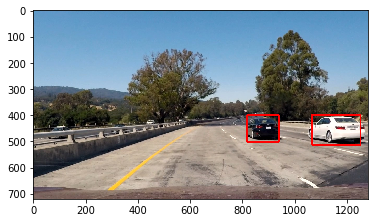

Number of windows with vehicles 1
Number of windows with vehicles 0
Number of windows with vehicles 1
Number of windows with vehicles 0


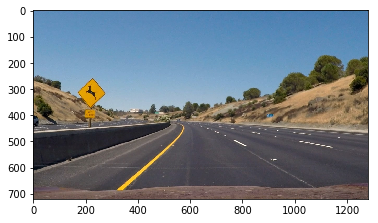

Number of windows with vehicles 0
Number of windows with vehicles 1
Number of windows with vehicles 0
Number of windows with vehicles 3


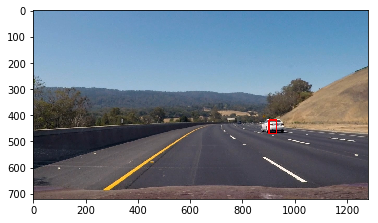

Number of windows with vehicles 9
Number of windows with vehicles 12
Number of windows with vehicles 19
Number of windows with vehicles 16


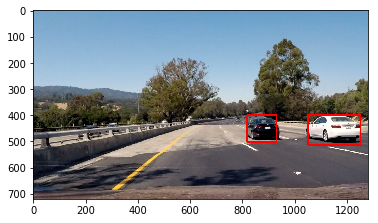

Number of windows with vehicles 7
Number of windows with vehicles 14
Number of windows with vehicles 17
Number of windows with vehicles 21


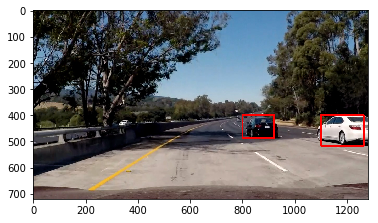

Number of windows with vehicles 10
Number of windows with vehicles 14
Number of windows with vehicles 18
Number of windows with vehicles 15


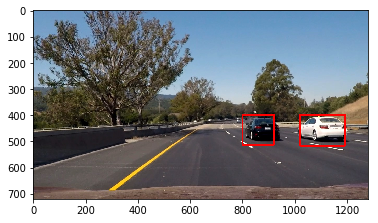

In [23]:
'''
Created on Nov 6, 2017

@author: andreas
'''
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.measurements import label

SlidingWindowParameters = namedtuple("SlidingWindowParameters", "xStart xStop yStart yStop xOverlap yOverlap xWindowSize yWindowSize")

#DefaultSlidingWindowParameters =  

class DetectingVehicles:
    def __init__(self):
        self.parameters = None
        self.data = DataHandling()
        self.Initialization()
        self.heatMap = None
        self.vehicleMarkings = []
    
    def Initialization(self):
        myColorSpace = "LUV"
        myHogParameters = HogParameters(isOn = True, orientationsCount = 72, pixelsPerCell = (16,16), cellsPerBlock = (4,4), visualize = False, channel = 'ALL')
        myColorParameters = ColorParameters(isOn = True, binCount = 128)
        mySpatialParameters = SpatialParameters(isOn =True, spatialSize = (8,8))
        classifierType = "LinearSVC"
        self.classifier = Classifier(classifierType)
        self.classifier.SetFeatureProcessingParameters(myHogParameters, myColorParameters, mySpatialParameters, myColorSpace)
        self.classifier.SetTrainingAndTestData(False)
        print("Initialization: Training the classifier ... ")
        self.classifier.TrainClassifier()
        print("... finished")

    
    def SetSlidingWindowParameters(self, image):
        height = image.shape[0] 
        width = image.shape[1]
        yFactor = 400./720.
        ySizeFactor = 260./720.
        yStart =  np.int(yFactor*height)
        yStop = yStart+np.int(ySizeFactor*height)
        self.parameters = SlidingWindowParameters(xStart = 0, xStop = width, yStart = yStart, yStop = yStop, xOverlap = 0.6, yOverlap = 0.6, xWindowSize = 64, yWindowSize =64 )
    
         
    ## We use a fixed Window search size and rescale the original image
    def SearchForVehicles(self, image, windowsList, scale):
        resultWindows = []
        countVehicle = 0
        countNonVehicle = 0
        rectangles = []
        for window in windowsList:
            #resizedImage = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            imageWindow = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
            #cv2.imshow("frame", resizedImage)
            #cv2.imshow("frame", image)
            #if cv2.waitKey(5000) & 0xFF == ord('q'):
            #    continue
            predictedLabel = self.classifier.UseClassifier(imageWindow)
            if predictedLabel == 1:
                leftTop = (np.int(window[0][0]/scale), np.int(window[0][1]/scale))
                rightBottom = (np.int(window[1][0]/scale), np.int(window[1][1]/scale))
                rectangle = [leftTop, rightBottom]
                rectangles.append(rectangle)
                countVehicle +=1
            else:
                countNonVehicle +=1
        print ("Number of windows with vehicles", countVehicle)
        return rectangles
    
    def AddToHeatMap(self, vehicleCoordinates):
        self.heatMap[vehicleCoordinates[0][1]:vehicleCoordinates[1][1], vehicleCoordinates[0][0]:vehicleCoordinates[1][0]] +=1
    
    
    def FinalizeHeatMap(self):
        self.heatMap[self.heatMap <= 2] = 0
        vehicleMarkings = label(self.heatMap)
        for vehicle in range(1, vehicleMarkings[1]+1):
            vehicleHeat = (vehicle == vehicleMarkings[0]).nonzero()
            yVehicle = np.array(vehicleHeat[0])
            xVehicle = np.array(vehicleHeat[1])
            rectangle = [(np.min(xVehicle), np.min(yVehicle)), (np.max(xVehicle), np.max(yVehicle))]
            self.vehicleMarkings.append(rectangle)
            
    
    def ProcessTestImages(self):
        images = self.data.LoadTestImages()
        scaleList = [0.75, 1.0,1.1, 1.25]
        for image in images:
            imageCopy = np.copy(image)
            self.heatMap = np.zeros_like(image[:,:,0])
            vehicles =[]
            for scale in scaleList:
                imageShape = image.shape
                resizedImage = cv2.resize(image, (np.int(imageShape[1]*scale), np.int(imageShape[0]*scale)))
                self.SetSlidingWindowParameters(resizedImage)
                windows = self.GetSlidingWindows(resizedImage)
                foundVehicles = self.SearchForVehicles(resizedImage, windows, scale)
                vehicles = vehicles + foundVehicles
            for vehicle in vehicles:
                self.AddToHeatMap(vehicle)
            self.FinalizeHeatMap()
            for vehicle in self.vehicleMarkings:
                imageCopy = cv2.rectangle(image,vehicle[0],vehicle[1],(0,0,255),6)
            self.ShowImageAsPlot(imageCopy)
                #            cv2.imshow("frame", imageCopy)
            self.vehicleMarkings = []
#            if cv2.waitKey(50000) & 0xFF == ord('q'):
#                continue

    def ShowImageAsPlot(self, image):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.show()

        
        
    def GetSlidingWindows(self,image):
    # If x and/or y start/stop positions not defined, set to image size
        #self.CheckParameters(image)

        scanningXSpan = self.parameters.xStop - self.parameters.xStart   
        scanningYSpan = self.parameters.yStop - self.parameters.yStart
        
        numberOfXPixelsPerStep = np.int(self.parameters.xWindowSize*(1.0 - self.parameters.xOverlap) )
        numberOfYPixelsPerStep = np.int(self.parameters.yWindowSize*(1.0 - self.parameters.yOverlap) )
        

        bufferX = np.int(self.parameters.xWindowSize*(self.parameters.xOverlap))
        bufferY = np.int(self.parameters.yWindowSize*(self.parameters.yOverlap))

        numberOfXWindows = np.int((scanningXSpan - bufferX)/numberOfXPixelsPerStep)
        numberOfYWindows = np.int((scanningYSpan - bufferY)/numberOfYPixelsPerStep)
        windowList = []
        for yIndex in range(numberOfYWindows):
            for xIndex in range(numberOfXWindows):
                # Calculate window position
                startX = xIndex*numberOfXPixelsPerStep + self.parameters.xStart  
                endX = startX + self.parameters.xWindowSize
                startY = yIndex*numberOfYPixelsPerStep + self.parameters.yStart  
                endY = startY + self.parameters.yWindowSize
                # Append window position to list
                windowList.append(((startX, startY), (endX, endY)))
        # Return the list of windows
        return windowList


test = DetectingVehicles()
test.ProcessTestImages()

## Project video
Next I applied my pipeline to the project video. The results were not satisfying because of 
- a significant of false positives
- flickering of the vehicle markings/bounding boxes
- bad detection of the white car between timetstamps 20 and 30 seconds of the video

To reduce the false positives and smoothen the vehicle markings I added a heatmap history which takes into account the heatmaps of the last two frames. Consequently I adpated the threshold (new value is seven) for the heatmap and experimented further with the
xOverlap, yOverlap and the image scaling. The heatmap history is implemeted as:

In [ ]:
##  Additional methods of the DetectingVehicle class implementing a heatmap history
    def AddToHeatMap(self, vehicleCoordinates):
        self.heatMap[vehicleCoordinates[0][1]:vehicleCoordinates[1][1], vehicleCoordinates[0][0]:vehicleCoordinates[1][0]] +=1
        
    
    def CalculateHeatMap(self):
        self.heatMapList.append(self.heatMap)
        if(len(self.heatMapList) < 2):
            return
        if(len(self.heatMapList) > 3):
            del self.heatMapList[0]
        self.heatMap = sum(self.heatMapList)
        
        
    def FinalizeHeatMap(self, video):
        threshold = 2
        if(video):
            self.CalculateHeatMap()
            threshold =7
        self.heatMap[self.heatMap <= threshold] = 0
        vehicleMarkings = label(self.heatMap)
        for vehicle in range(1, vehicleMarkings[1]+1):
            vehicleHeat = (vehicle == vehicleMarkings[0]).nonzero()
            
            yVehicle = np.array(vehicleHeat[0])
            xVehicle = np.array(vehicleHeat[1])
            rectangle = [(np.min(xVehicle), np.min(yVehicle)), (np.max(xVehicle), np.max(yVehicle))]
            self.vehicleMarkings.append(rectangle)
            

For the video I also found more suitable image scaling and sliding window overlap parameters

- xOverlap = 0.5
- yOverlap = 0.5
- List of image scaling factors: [0.75, 1.0, 1.25]

For the remaining white car problem I tried data augmentation including

- scaling with factor 0.8 and 1.2
- translation +/-4 pixels
- rotation of +/- 15 degree

for 

- vehicle data only
- non-vehicle data only
- both of the above

and found no significant improvement of the classifier (rather the opposite). Then I went back to the feature processing parameters and tried other color spaces (e.g. YCrCb), excluding hog features and found that information from spatial features 
might be more useful for classification. Therefore I adapted my parameter setting for feature processing to be:

- Color space = LUV
- HOG parameters: orientationsCount = 16, pixelsPerCell = (16,16), cellsPerBlock = (4,4), channel = 'ALL'
- Color parameters: binCount = 128
- Spatial parameters: spatialSize = (24,24)

With this setup the resulting video has very low rate of false positives and the detection of the white car has improved.
## Summary and outlook
I enjoyed the project very much, in particular the exploration of different classifiers. In the near future I will study the math behind these traditional machine learning algorithms in more detail. In addition I am surprised how many problems are still unsolved even if you have a "well performing" classifier. What bothers me about my pipeline is the video processing time (on my i5-7400 CPU with 8 GB RAM) which is orders of magnitude from real time processing. I needed about 40 min processing time for 45 seconds of video and I am be very interested how to achieve a reasonable processing time.